### Text Vectorization

In the previous notebook we have looked at how we can do text tokenization and some various text processing using `spacy` library. In this notebook we are going to cover some text vectorization, which is the process of converting sequence of words into sequence of numbers. We are going to look at the `Bag of Words (BOW)` and later on we are going to calculate the `cosine similarity` between documents.

First thing first we need to install the latest version of `spacy` by running the following command:

In [1]:
!pip install -U spacy==3.* -q

We can check the information about this spacy library by running the following command.

In [2]:
!python -m spacy info

2023-08-15 05:51:36.273702: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-15 05:51:37.675279: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

============================== Info about spaCy ==============================

spaCy version    3.6.1                         
Location         /usr/local/lib/python3.10/dist-packages/spacy
Platform         Linux-5.15.109+-x86_64-with-glibc2.35
Python version   3.10.12                       
Pipelines        en_core_web_sm (3.6.0)        



Since we have downloaded `spacy` version `3.*` we must also upgrade the language model `en_core_web_sm`. **`en_core_web_sm`** is a statistical model that we are going to use to process some english sentences. These statistical models can be found at [spacy.io](https://spacy.io/models/en#en_core_web_sm) and they helped us with tokenization, part-of-speech tagging, named entity recognition, etc.

In [3]:
!python -m spacy download en_core_web_sm -q

2023-08-15 05:51:50.213236: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-15 05:51:51.632713: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 24.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In the following code cell we are going to import all the packages that we are going to use in this notebook.

In [65]:
import spacy

import numpy as np

from scipy import spatial
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.datasets import fetch_20newsgroups

spacy.__version__

'3.6.1'

Let's say we have the following corpus. Which is basically raw text documents.

In [6]:
corpus = [
  "Red Bull drops hint on F1 engine.",
  "Honda exits F1, leaving F1 partner Red Bull.",
  "Hamilton eyes record eighth F1 title.",
  "Aston Martin announces sponsor."
]



### BOW
A bag-of-words is a representation of text that describes the occurrence of words within a document. This representation includes:

* vocabulary of known words
* a measure of the presence of known words.

> It is called a `“bag”` of words, because any **information about the order or structure of words in the document is discarded**. The model is only concerned with whether known words occur in the document, not where in the document.

Before anything, let's go through how the `bow` works from our corpus, asuming that each line is a document.





In [13]:
nlp = spacy.load('en_core_web_sm')
words = []
for sent in corpus:
  doc = nlp(sent)
  words.extend([token.text.lower() for token in doc if not token.is_punct])
vocab = set(words)
print(vocab)
print("Vocab size: {}".format(len(vocab)))

{'eyes', 'eighth', 'martin', 'red', 'partner', 'drops', 'announces', 'sponsor', 'honda', 'hint', 'engine', 'title', 'on', 'bull', 'record', 'leaving', 'exits', 'aston', 'hamilton', 'f1'}
Vocab size: 20


From the above code cell we have created the set of unique words that are in our `corpus` by casefolding and filtering punctuations. And we have seen that the vocabulary size is `20` which is the total number of unique words in the corpus.

Now we can create vectors from each document in our corpus. The simplest scoring method is to mark the presence of words as a boolean value, 0 for absent, 1 for present. This is known as `binary bag of words` and for our first `""Red Bull drops hint on F1 engine.""` sentence in the corpus we might end up with something that looks as follows:

In [33]:
def get_bow(sent, binary=True):
  doc = nlp(sent)
  tokens = [t.text.lower() for t in doc if not t.is_punct]
  indices = [list(vocab).index(t) for t in tokens]
  bow = np.zeros(len(vocab), dtype=np.float32)
  if binary:
    bow[np.array(indices)] = 1
  else:
     bow[np.array(indices)] = np.array([indices.count(i) for i in indices])
  return bow

# "Red Bull drops hint on F1 engine."
get_bow(corpus[0])

array([0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0.,
       0., 0., 1.], dtype=float32)

In [34]:
get_bow(corpus[1])

array([0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1.,
       0., 0., 1.], dtype=float32)

> Note that there is another `bow` technique which returns the frequecy of that word in a document rather than a binary version which discard how many times the word occur. Let's have a look at the second document in our `corpus`.

In [23]:
corpus[1]

'Honda exits F1, leaving F1 partner Red Bull.'

The word `F1` is repeating twice, in the previous example the index of this word was set to `1` in the bow, though it appears twice. We can modify the call of our `get_bow` and set binary to false as follows.

In [36]:
get_bow(corpus[1], False)

array([0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1.,
       0., 0., 2.], dtype=float32)


Fortunately, there are robust libraries which make it easy. From the above corpus we will want to create a basic `Bag of Words (BOW)` representation of our corpus. For that we can use the `scikit-learn` `CountVectorizer` which creates the matrix of token counts from a collection of text documents. You can read more about the CountVectorizer [here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer.fit_transform)

In [37]:
vectorizer = CountVectorizer()
bow = vectorizer.fit_transform(corpus)

We can take a look at the features and vocabulary dictionary. Notice the `CountVectorizer` took care of tokenization for us. It also removed punctuation and lower-cased everything

In [38]:
vectorizer.get_feature_names_out()

array(['announces', 'aston', 'bull', 'drops', 'eighth', 'engine', 'exits',
       'eyes', 'f1', 'hamilton', 'hint', 'honda', 'leaving', 'martin',
       'on', 'partner', 'record', 'red', 'sponsor', 'title'], dtype=object)

In [39]:
vectorizer.vocabulary_

{'red': 17,
 'bull': 2,
 'drops': 3,
 'hint': 10,
 'on': 14,
 'f1': 8,
 'engine': 5,
 'honda': 11,
 'exits': 6,
 'leaving': 12,
 'partner': 15,
 'hamilton': 9,
 'eyes': 7,
 'record': 16,
 'eighth': 4,
 'title': 19,
 'aston': 1,
 'martin': 13,
 'announces': 0,
 'sponsor': 18}

Specifically, the `CountVectorizer` generates a sparse matrix using an efficient, compressed representation. The sparse matrix object includes a number of useful methods we can explore those methods [here](
https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html)

In [40]:
type(bow)

scipy.sparse._csr.csr_matrix

If we look at the raw structure, we'll see tuples where the first element represents the document, and the second element represents a token ID. It's then followed by a count of that token. So in the second document (index 1), token 8 ("f1") occurs twice.

In [41]:
print(bow)

  (0, 17)	1
  (0, 2)	1
  (0, 3)	1
  (0, 10)	1
  (0, 14)	1
  (0, 8)	1
  (0, 5)	1
  (1, 17)	1
  (1, 2)	1
  (1, 8)	2
  (1, 11)	1
  (1, 6)	1
  (1, 12)	1
  (1, 15)	1
  (2, 8)	1
  (2, 9)	1
  (2, 7)	1
  (2, 16)	1
  (2, 4)	1
  (2, 19)	1
  (3, 1)	1
  (3, 13)	1
  (3, 0)	1
  (3, 18)	1


`CountVectorizer` also supports a custom tokenizer. For every document, it will call your tokenizer and expect a list of tokens returned.

In [42]:
def spacy_tokenizer(sent):
  return [t.text for t in nlp(sent) if not t.is_punct]

This time, we instantiate `CountVectorizer` with our custom tokenizer (`spacy_tokenizer`), as a kewword arg and also set the `binary` parameter to `True` so we simply get `1s` and `0s` marking token presence rather than token frequency.

In [44]:
vectorizer = CountVectorizer(tokenizer=spacy_tokenizer,
                              binary=True)
bow = vectorizer.fit_transform(corpus)

To get a dense array representation of our sparse matrix, we use `toarray()` method.

In [45]:
print(bow.toarray())

[[0 0 1 1 0 1 0 0 1 0 1 0 0 0 1 0 0 1 0 0]
 [0 0 1 0 0 0 1 0 1 0 0 1 1 0 0 1 0 1 0 0]
 [0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 1 0 0 1]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0]]


In [48]:
print(bow[0].toarray())
print()
print(bow[0:2].toarray())

[[0 0 1 1 0 1 0 0 1 0 1 0 0 0 1 0 0 1 0 0]]

[[0 0 1 1 0 1 0 0 1 0 1 0 0 0 1 0 0 1 0 0]
 [0 0 1 0 0 0 1 0 1 0 0 1 1 0 0 1 0 1 0 0]]


### Cosine Similarity

Now that we have learn how to vectorize our tokens using the `bow` technique. In this section we are going to calculate the `cosine_similarity` between documents.

Writing our own cosine similarity function is straight-forward using numpy. There are multiple ways to calculate it using scipy.

One way is using the `spatial` package, which is a collection of spatial algorithms and data structures. It has a method to calculate cosine `distance`. To get the cosine `similarity`, we have to substract the distance from 1. You can read more about it [here.](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cosine.html#scipy.spatial.distance.cosine)


In [51]:
doc1_vs_doc2 = 1 - spatial.distance.cosine(bow[0].toarray().squeeze(), bow[1].toarray().squeeze())
doc1_vs_doc3 = 1 - spatial.distance.cosine(bow[0].toarray().squeeze(), bow[2].toarray().squeeze())
doc1_vs_doc4 = 1 - spatial.distance.cosine(bow[0].toarray().squeeze(), bow[3].toarray().squeeze())

print(corpus)

print(f"Doc 1 vs Doc 2: {doc1_vs_doc2}")
print(f"Doc 1 vs Doc 3: {doc1_vs_doc3}")
print(f"Doc 1 vs Doc 4: {doc1_vs_doc4}")

['Red Bull drops hint on F1 engine.', 'Honda exits F1, leaving F1 partner Red Bull.', 'Hamilton eyes record eighth F1 title.', 'Aston Martin announces sponsor.']
Doc 1 vs Doc 2: 0.4285714285714286
Doc 1 vs Doc 3: 0.15430334996209194
Doc 1 vs Doc 4: 0.0


Another approach is using scikit-learn's `cosine_similarity` which computes the metric between multiple vectors. Here, we pass it our BOW and get a matrix of cosine similarities between each document and you can read more about it [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html).

In [54]:
cosine_similarity(bow)

array([[1.        , 0.42857143, 0.15430335, 0.        ],
       [0.42857143, 1.        , 0.15430335, 0.        ],
       [0.15430335, 0.15430335, 1.        , 0.        ],
       [0.        , 0.        , 0.        , 1.        ]])

The cosine_similarity function can be created using numpy. In the following code cell we are going to create this function. The formular is as follows:

<p align="center">
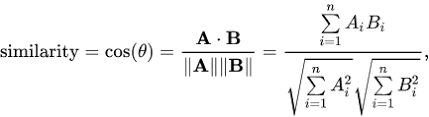
</p>

The formular can be found in one of my notebooks [here.](https://github.com/CrispenGari/recommentation-algorithms/blob/main/00_ML/00_MOVIE_RECOMMENTATION_SYSTEM/00_MOVIE_RECOMMENTATION_SYSTEM.ipynb) Together with these two links:

1. https://numpy.org/doc/stable/reference/generated/numpy.dot.html
2. https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html

We can come up with the following function:




In [62]:
def cos_sim(a, b):
  return np.sum(a * b)/ (np.sqrt(np.sum(np.square(a))) * np.sqrt(np.sum(np.square(a))))

In [64]:
doc1_vs_doc2 = cos_sim(bow[0].toarray().squeeze(), bow[1].toarray().squeeze())
doc1_vs_doc3 = cos_sim(bow[0].toarray().squeeze(), bow[2].toarray().squeeze())
doc1_vs_doc4 = cos_sim(bow[0].toarray().squeeze(), bow[3].toarray().squeeze())

print(corpus)

print(f"Doc 1 vs Doc 2: {doc1_vs_doc2}")
print(f"Doc 1 vs Doc 3: {doc1_vs_doc3}")
print(f"Doc 1 vs Doc 4: {doc1_vs_doc4}")

['Red Bull drops hint on F1 engine.', 'Honda exits F1, leaving F1 partner Red Bull.', 'Hamilton eyes record eighth F1 title.', 'Aston Martin announces sponsor.']
Doc 1 vs Doc 2: 0.4285714285714285
Doc 1 vs Doc 3: 0.14285714285714285
Doc 1 vs Doc 4: 0.0


### N-Grams

The `CountVectorizer` includes an `ngram_range` parameter to generate different `n-grams`. `n_gram` range is specified using a minimum and maximum range. By default, `n_gram range` is set to `(1, 1)` which generates unigrams. Setting it to `(1, 2)` generates both unigrams and bigrams and setting it to `(2, 2)` will generate oly bigrams.


In [56]:
vectorizer = CountVectorizer(tokenizer=spacy_tokenizer, binary=True,
                             ngram_range=(2,2)
                             )
bigrams = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names_out())
print(vectorizer.vocabulary_)

['announces sponsor' 'aston martin' 'bull drops' 'drops hint' 'eighth f1'
 'exits f1' 'eyes record' 'f1 engine' 'f1 leaving' 'f1 partner' 'f1 title'
 'hamilton eyes' 'hint on' 'honda exits' 'leaving f1' 'martin announces'
 'on f1' 'partner red' 'record eighth' 'red bull']
{'red bull': 19, 'bull drops': 2, 'drops hint': 3, 'hint on': 12, 'on f1': 16, 'f1 engine': 7, 'honda exits': 13, 'exits f1': 5, 'f1 leaving': 8, 'leaving f1': 14, 'f1 partner': 9, 'partner red': 17, 'hamilton eyes': 11, 'eyes record': 6, 'record eighth': 18, 'eighth f1': 4, 'f1 title': 10, 'aston martin': 1, 'martin announces': 15, 'announces sponsor': 0}


### Term Frequecy - Inverse Document Frequecy (TF-IDF)

> _A problem with scoring word frequency is that highly frequent words start to dominate in the document (e.g. larger score), but may not contain as much “informational content” to the model as rarer but perhaps domain specific words._

One approach is to rescale the frequency of words by how often they appear in all documents, so that the scores for frequent words like `“the”` that are also frequent across all documents are penalized.

* **Term Frequency**: is a scoring of the frequency of the word in the current document.
* **Inverse Document Frequency**: is a scoring of how rare the word is across documents.


In this section we are going to use a larger [`dataset.scikit-learn.datasets`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets) fetch popular reference datasets online.

We'll use the [`20 newsgroups`](https://scikit-learn.org/stable/datasets/real_world.html#the-20-newsgroups-text-dataset) dataset, which is a collection of 18,000 newsgroup posts across 20 topics.


In [66]:
corpus = fetch_20newsgroups(categories=['sci.space'],
                            remove=('headers', 'footers', 'quotes'))

We can check the number of posts in our dataset as follows:

In [67]:
len(corpus.data)

593

We can check the first two post as follows:

In [68]:
corpus.data[:2]

["\nAny lunar satellite needs fuel to do regular orbit corrections, and when\nits fuel runs out it will crash within months.  The orbits of the Apollo\nmotherships changed noticeably during lunar missions lasting only a few\ndays.  It is *possible* that there are stable orbits here and there --\nthe Moon's gravitational field is poorly mapped -- but we know of none.\n\nPerturbations from Sun and Earth are relatively minor issues at low\naltitudes.  The big problem is that the Moon's own gravitational field\nis quite lumpy due to the irregular distribution of mass within the Moon.",
 '\nGlad to see Griffin is spending his time on engineering rather than on\nritual purification of the language.  Pity he got stuck with the turkey\nrather than one of the sensible options.']

Next we are going to create our custom tokenizer, and we are going to filter out `ner` and `parser` so that this will speed the tokenization process.

In [69]:
unwanted_pipes = ["ner", "parser"]

def spacy_tokenizer(doc):
  with nlp.disable_pipes(*unwanted_pipes):
    return [t.lemma_ for t in nlp(doc) if not t.is_punct and not t.is_space and t.is_alpha]

Like the classes to create raw frequency and binary bag-of-words vectors, scikit-learn includes a similar class called [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)to create TF-IDF vectors from a corpus.


In [70]:
vectorizer = TfidfVectorizer(tokenizer=spacy_tokenizer)
features = vectorizer.fit_transform(corpus.data)
print(len(vectorizer.get_feature_names_out()))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


9440


The dimensions of our feature matrix. X rows (documents) by Y columns (tokens).


In [71]:
features.shape

(593, 9440)

What the encoding of the first document looks like in sparse format.

In [72]:
print(features[0])

  (0, 5064)	0.10452754121963853
  (0, 2351)	0.12747025764625855
  (0, 4340)	0.15331700873692364
  (0, 2459)	0.10862435105627101
  (0, 4916)	0.17102715751031994
  (0, 6702)	0.09940033595823265
  (0, 5982)	0.10183554382071024
  (0, 6514)	0.08455482269873241
  (0, 896)	0.0892999596249832
  (0, 316)	0.1109487112663238
  (0, 4896)	0.08247641364333849
  (0, 628)	0.051044670776703174
  (0, 4368)	0.10270174012167517
  (0, 5274)	0.13259746290766442
  (0, 6908)	0.12524708704889775
  (0, 2494)	0.07376562213268434
  (0, 8105)	0.09513204666042695
  (0, 3287)	0.051874685324429695
  (0, 6181)	0.1390186329543497
  (0, 5652)	0.11219531673533985
  (0, 4589)	0.06321728493925476
  (0, 9158)	0.06158004812009137
  (0, 1141)	0.048918909156680825
  (0, 5023)	0.12320196834845284
  (0, 6354)	0.15331700873692364
  :	:
  (0, 1344)	0.09036471134545682
  (0, 5403)	0.17102715751031994
  (0, 451)	0.10452754121963853
  (0, 5790)	0.0991335109087398
  (0, 8368)	0.20402991671500817
  (0, 5377)	0.10099775257415368
  (0, 9

The similarity measuring techniques we learned in the last section can be used here in the same way. In effect, we can query our data using this sequence:

1. `Transform` our query using the same vocabulary from our `fit` step on our corpus.
2. `Calculate` the pairwise cosine similarities between each document in our corpus and our query.
3. `Sort` them in descending order by score.

In [77]:
query = ["lunar orbit"]
query_tfidf = vectorizer.transform(query)
query_tfidf.toarray()

array([[0., 0., 0., ..., 0., 0., 0.]])

In [81]:
cosine_similarities = cosine_similarity(features, query_tfidf).flatten()


Now that we have our list of cosine similarities, we can use this utility function to return the indices of the top k documents with the highest cosine similarities.

In [82]:
def top_k(arr, k):
  kth_largest = (k + 1) * -1
  return np.argsort(arr)[:kth_largest:-1]

In [83]:
top_related_indices = top_k(cosine_similarities, 5)
top_related_indices

array([249, 108,   0, 312, 509])

Let's take a look at their respective cosine similarities.

In [84]:
print(cosine_similarities[top_related_indices])

[0.47855355 0.4292246  0.2736328  0.19486489 0.19125175]


Top match.

In [85]:
print(corpus.data[top_related_indices[0]])


Actually, Hiten wasn't originally intended to go into lunar orbit at all,
so it indeed didn't have much fuel on hand.  The lunar-orbit mission was
an afterthought, after Hagoromo (a tiny subsatellite deployed by Hiten
during a lunar flyby) had a transmitter failure and its proper insertion
into lunar orbit couldn't be positively confirmed.

It should be noted that the technique does have disadvantages.  It takes
a long time, and you end up with a relatively inconvenient lunar orbit.
If you want something useful like a low circular polar orbit, you do have
to plan to expend a certain amount of fuel, although it is reduced from
what you'd need for the brute-force approach.


### Limitations of BoW

Bag of words suffers from:

* `Vocabulary`: The vocabulary requires careful design, most specifically in order to manage the size, which impacts the sparsity of the document representations.
* `Sparsity`: Sparse representations are harder to model both for computational reasons (space and time complexity) and also for information reasons, where the challenge is for the models to harness so little information in such a large representational space.
* `Meaning`: Discarding word order ignores the context, and in turn meaning of words in the document (semantics). Context and meaning can offer a lot to the model, that if modeled could tell the difference between the same words differently arranged (“this is interesting” vs “is this interesting”), synonyms (“old bike” vs “used bike”), and much more.



#### Refs

1. https://spacy.io/usage/spacy-101
2. https://machinelearningmastery.com/gentle-introduction-bag-words-model/
3. https://docs.scipy.org/doc/scipy/reference/spatial.html